In [2]:
period=-4800
time_interval='1d'
crypto_tickers = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'XRP-USD']

%run crypto_data_loader.ipynb

yfinance version: 0.2.47
Start load crypto data with interval: 1d, from: 2011-10-10 20:28:35.034308


[*********************100%***********************]  4 of 4 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3728 entries, 2014-09-17 00:00:00+00:00 to 2024-11-30 00:00:00+00:00
Freq: D
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (BTC-USD, Adj Close)  3728 non-null   float64
 1   (ETH-USD, Adj Close)  2579 non-null   float64
 2   (SOL-USD, Adj Close)  1696 non-null   float64
 3   (XRP-USD, Adj Close)  2579 non-null   float64
 4   (BTC-USD, Close)      3728 non-null   float64
 5   (ETH-USD, Close)      2579 non-null   float64
 6   (SOL-USD, Close)      1696 non-null   float64
 7   (XRP-USD, Close)      2579 non-null   float64
 8   (BTC-USD, High)       3728 non-null   float64
 9   (ETH-USD, High)       2579 non-null   float64
 10  (SOL-USD, High)       1696 non-null   float64
 11  (XRP-USD, High)       2579 non-null   float64
 12  (BTC-USD, Low)        3728 non-null   float64
 13  (ETH-USD, Low)        2579 non-null   float64
 14  (SOL-USD, Low)  

In [3]:
import os
import pandas as pd
import talib as ta
from talib import MA_Type
import warnings
from tqdm import tqdm
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import backtesting
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')

/home/alex/workspaces/ML/wrk/hw1/otus/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Usefull functions

In [4]:
%run file_loader.ipynb
%run useful_functions.ipynb

### Loading data and Calculate Bollinger Bands and RSI and apply Signal

In [5]:
dir = "crypto_data"
crypto_dict = {}
for name in crypto_tickers:
    f = os.path.join(dir, name+'.csv')
    if os.path.isfile(f):
        df = loading_v3(f)
        df = df.dropna()
        df = df[df.High != df.Low]
        df['bb_up'], df['bb_mid'], df['bb_low'] = ta.BBANDS(df["Close"], timeperiod=30, matype=MA_Type.EMA)
        df['bb_width'] = (df['bb_up'] - df['bb_low']) / df['bb_mid']
        df['rsi'] = ta.RSI(df['Close'], timeperiod=14)
        df["atr"] = ta.ATR(low = df['Low'], close = df['Close'], high = df['High'], timeperiod=14)

        add_bb_rsi_signal(df=df, rsi_threshold_low=30, rsi_threshold_high=70, bb_width_threshold=0.001)
        
        df = df.sort_values('Date').reset_index(drop=True)
        df = df.set_index('Date')

        crypto_dict[name] = df


In [17]:
crypto_dict['SOL-USD'].describe()

,Close,High,Low,Open,Volume,chg,vol_chg,bb_up,bb_mid,bb_low,bb_width,rsi,atr,Signal,pointpos
count,1696.000000,1696.000000,1696.000000,1696.000000,1.696000e+03,1696.000000,1696.000000,1667.000000,1667.000000,1667.000000,1667.000000,1682.000000,1682.000000,1696.000000,11.000000
mean,65.965790,68.538342,63.215303,65.841027,1.508994e+09,0.555761,10.054387,80.452078,65.188156,49.924235,0.534839,52.540021,5.265445,0.007075,47.108897
std,65.719432,68.034261,63.131711,65.631191,1.826591e+09,6.809492,55.763420,76.564306,62.801960,50.646707,0.329535,13.622012,5.184776,0.090606,61.056500
min,0.515273,0.559759,0.505194,0.513391,6.520200e+05,-42.280000,-73.940000,0.661446,0.600029,0.383286,0.118281,21.240735,0.045442,0.000000,1.375067
25%,16.351248,17.280933,15.484198,16.329261,2.365089e+08,-3.090000,-23.475000,22.542413,18.712543,12.777728,0.297563,42.703456,1.076736,0.000000,5.294664
50%,33.586504,35.085751,32.215662,33.535837,9.451789e+08,0.020000,-1.495000,44.834627,34.820594,25.450879,0.440392,50.732713,3.173336,0.000000,17.695544
75%,120.811230,128.557175,111.821276,119.282551,2.251311e+09,3.702500,26.660000,155.964575,118.858964,85.546670,0.662659,61.672223,8.584927,0.000000,66.182042
max,258.934326,263.831543,253.187439,258.781555,1.706864e+10,47.280000,472.650000,280.838482,220.657793,178.312666,1.882410,90.040039,21.364028,2.000000,177.192040


### Checks the count of entry and exit signals for each ticker

In [7]:
sum([crypto_dict[key]['Signal'].value_counts() for key in crypto_dict], start=0)

Signal
0    10523
1       43
2       16
Name: count, dtype: int64

In [8]:
# Checks the count of signals for each ticker
for df in crypto_dict.values():
    print(len(df[df.Signal != 0]))

20
14
11
14


In [ ]:
# Add position points
for df in crypto_dict.values():
    df = add_pointpos_column(df, "Signal", 1e-4)

# crypto_dict['BTC-USD'].describe()

,Close,High,Low,Open,Volume,chg,vol_chg,bb_up,bb_mid,bb_low,bb_width,rsi,atr,Signal,pointpos
count,3728.000000,3728.000000,3728.000000,3728.000000,3.728000e+03,3728.000000,3728.000000,3699.000000,3699.000000,3699.000000,3699.000000,3714.000000,3714.000000,3728.000000,20.000000
mean,18931.938473,19335.930221,18463.122419,18907.314037,1.818887e+10,0.209992,5.755247,21337.729147,18733.976480,16130.223813,0.286900,53.452784,864.806233,0.006706,10215.763606
std,21016.490701,21452.102703,20506.577536,20981.828094,1.978851e+10,3.628908,38.784416,23171.026851,20439.137855,17904.432738,0.176384,14.083702,1030.649360,0.096674,13567.899191
min,178.102997,211.731003,171.509995,176.897003,5.914570e+06,-37.170000,-86.920000,241.936958,231.205444,170.555100,0.036090,9.920239,3.555662,0.000000,271.668099
25%,1203.850006,1221.267487,1179.527466,1199.207520,3.527190e+08,-1.252500,-15.080000,1331.394205,1197.717814,1039.219607,0.160700,43.499941,55.783084,0.000000,1689.887612
50%,9298.575684,9453.876953,9139.787109,9291.900879,1.445021e+10,0.135000,-0.825000,10551.015443,9287.828114,7702.122804,0.252617,52.360855,384.744360,0.000000,5947.099998
75%,30254.632324,30633.783691,29641.748047,30236.093262,2.923162e+10,1.702500,18.597500,34275.797871,29828.704977,26249.716999,0.373278,62.468021,1379.155564,0.000000,12353.394631
max,98997.664062,99655.500000,97232.890625,99006.742188,3.509679e+11,25.250000,543.900000,108700.900429,87980.551233,67260.202037,1.161253,94.302215,5003.114239,2.000000,47145.566506


In [ ]:
st=0
for name, df in crypto_dict.items():
    dfpl = df[st:st+350]

    # Create a plot with 2 rows
    fig = make_subplots(rows=2, cols=1, column_titles=[name])

    # Add candlestick plot on the first row
    fig.add_trace(go.Candlestick(x=dfpl.index,
                                open=dfpl['Open'],
                                high=dfpl['High'],
                                low=dfpl['Low'],
                                close=dfpl['Close']),
                row=1, col=1)

    # Add Bollinger Bands, EMA lines on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['bb_low'],
                            line=dict(color='green', width=1),
                            name="BB_Low"),
                row=1, col=1)
    
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['bb_mid'],
                            line=dict(color='yellow', width=1),
                            name="BB_MID"),
                row=1, col=1)

    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['bb_up'],
                            line=dict(color='green', width=1),
                            name="BB_UPPER"),
                row=1, col=1)

    # Add markers for trade entry points on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                            marker=dict(size=8, color="MediumPurple"),
                            name="entry"),
                row=1, col=1)

    # Add markers for trade entry points on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['rsi'], 
                            line=dict(color='brown', width=2),
                            name="RSI"),
                row=2, col=1)

    fig.update_layout(width=800, height=600, sliders=[])
    fig.show()


In [ ]:
%run backtest_strategy.ipynb

In [12]:
results = dict()

for name, df in crypto_dict.items():
    bt = Backtest(df, BBRSIStrategy, cash=10000, margin=1/10, commission=0.002)
    stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 16)],
                    TPcoef=[i/10 for i in range(10, 21)],
                    maximize='Return [%]', max_tries=300,
                    random_state=0,
                    return_heatmap=True)
    results[name] = [stats, heatmap]


### Stats


In [13]:
for name, result_list in results.items():
    print("=== Stats of {} ===".format(name))
    print(result_list[0])


=== Stats of BTC-USD ===
Start                     2014-09-17 00:00...
End                       2024-11-30 00:00...
Duration                   3727 days 00:00:00
Exposure Time [%]                    2.306867
Equity Final [$]                 11264.815714
Equity Peak [$]                  11783.372251
Return [%]                          12.648157
Buy & Hold Return [%]            21043.425806
Return (Ann.) [%]                    1.172898
Volatility (Ann.) [%]                7.532174
Sharpe Ratio                         0.155718
Sortino Ratio                        0.287702
Calmar Ratio                         0.101449
Max. Drawdown [%]                  -11.561427
Avg. Drawdown [%]                   -5.356484
Max. Drawdown Duration     1581 days 00:00:00
Avg. Drawdown Duration      293 days 00:00:00
# Trades                                   15
Win Rate [%]                             40.0
Best Trade [%]                      14.612244
Worst Trade [%]                      -7.36899
Avg. Trad

### Heatmap

=== heatmap of BTC-USD ===


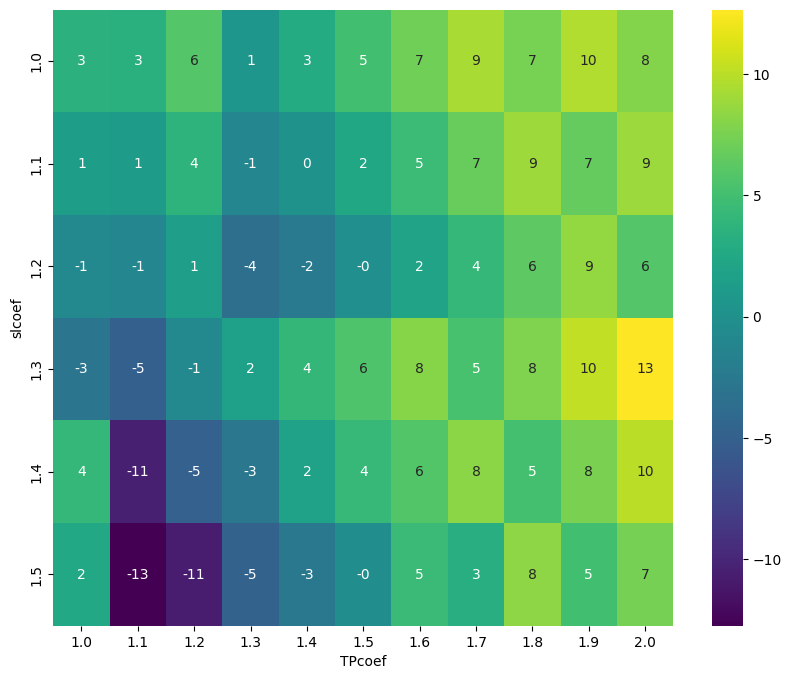

=== heatmap of ETH-USD ===


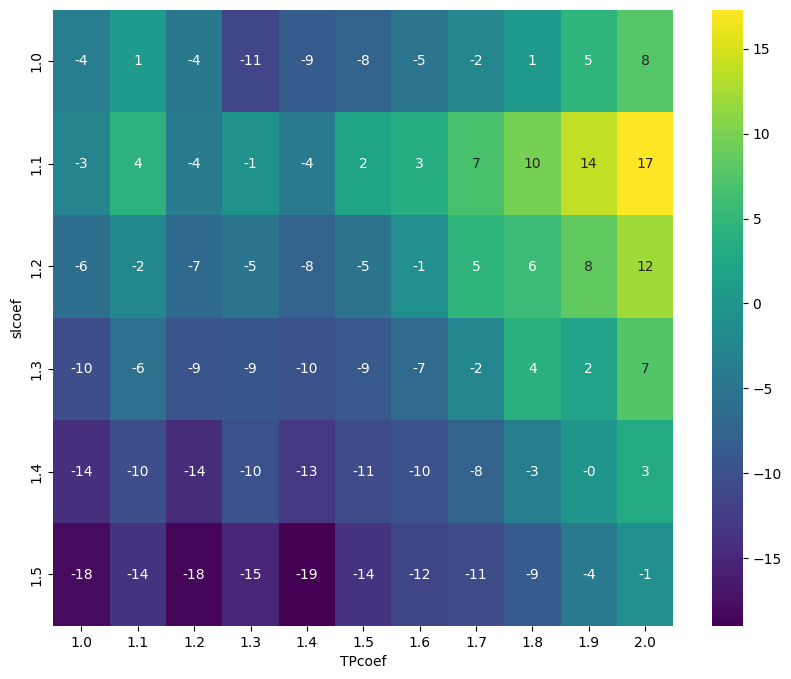

=== heatmap of SOL-USD ===


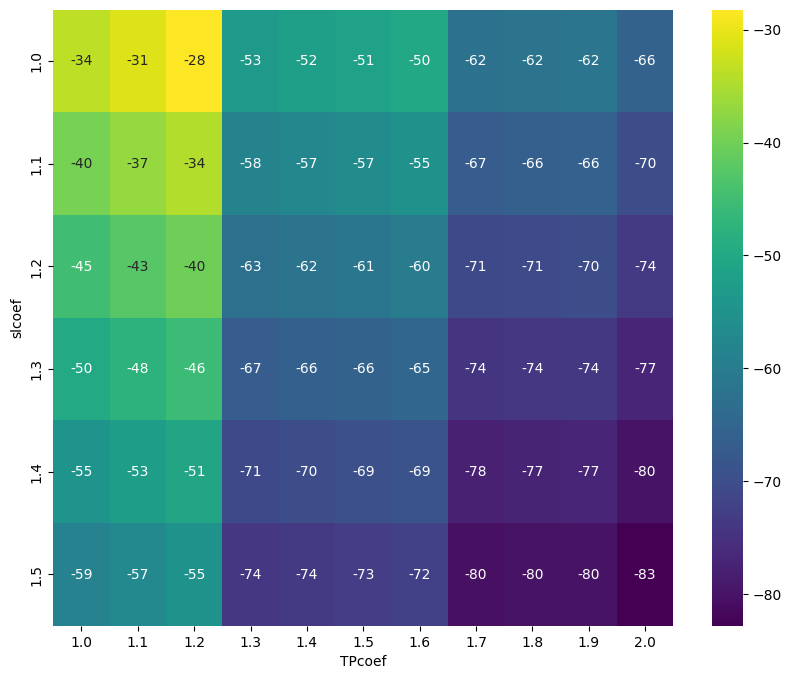

=== heatmap of XRP-USD ===


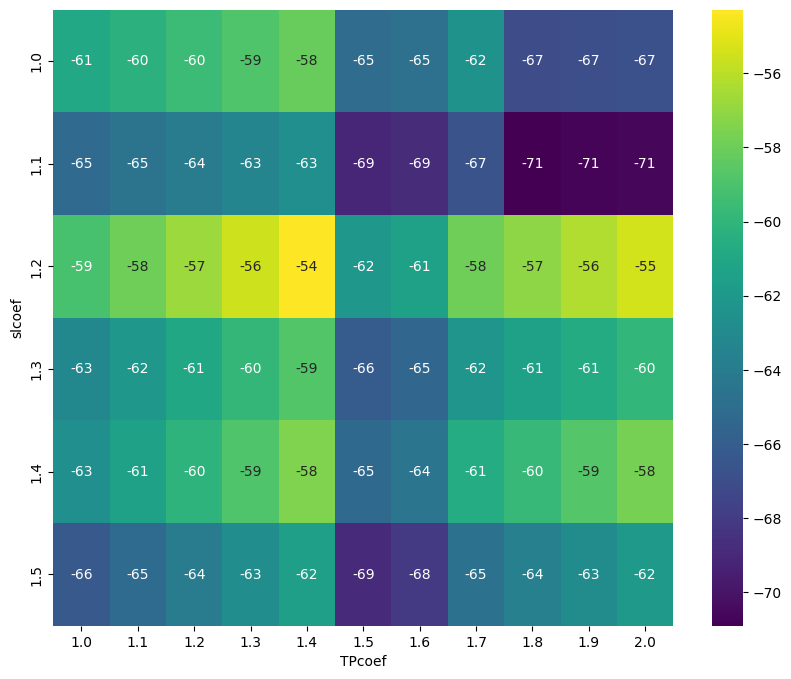

In [14]:
import seaborn as sns

for name, result_list in results.items():
    print("=== heatmap of {} ===".format(name))
    heatmap_df = result_list[1].unstack()
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
    plt.show()